# Telegram Data Analysis with dbt Models

This notebook demonstrates how to work with the dbt models and perform comprehensive analysis on the Telegram medical data pipeline.

## Objectives
- Connect to the PostgreSQL database with dbt models
- Explore the data structure and quality
- Perform descriptive analytics
- Create visualizations
- Generate insights from the Telegram messages

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Database connection
from sqlalchemy import create_engine, text
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All imports successful!")

✅ All imports successful!


## Database Connection

In [2]:
# Database connection setup
db_host = os.getenv('POSTGRES_HOST', 'localhost')
db_port = os.getenv('POSTGRES_PORT', '5432')
db_name = os.getenv('POSTGRES_DB', 'telegram_medical')
db_user = os.getenv('POSTGRES_USER', 'postgres')
db_password = os.getenv('POSTGRES_PASSWORD', '')

# Create database URL
database_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(database_url)

print(f"🔗 Connecting to database: {db_name} on {db_host}:{db_port}")

# Test connection
try:
    with engine.connect() as conn:
        result = conn.execute(text("SELECT 1"))
        print("✅ Database connection successful!")
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please check your .env file and ensure PostgreSQL is running.")

🔗 Connecting to database: telegram_medical on 127.0.0.1:5432
✅ Database connection successful!


## Data Overview

In [3]:
# Check if dbt models exist
def check_table_exists(table_name, schema='public'):
    """Check if a table exists in the database"""
    try:
        with engine.connect() as conn:
            result = conn.execute(text(f"""
                SELECT EXISTS (
                    SELECT FROM information_schema.tables 
                    WHERE table_schema = '{schema}' 
                    AND table_name = '{table_name}'
                );
            """))
            return result.fetchone()[0]
    except Exception as e:
        print(f"Error checking table {table_name}: {e}")
        return False

# Check raw data
raw_exists = check_table_exists('telegram_messages', 'raw')
print(f"📊 Raw data table exists: {raw_exists}")

# Check dbt models
staging_exists = check_table_exists('stg_telegram_messages')
dim_channels_exists = check_table_exists('dim_channels')
dim_dates_exists = check_table_exists('dim_dates')
fct_messages_exists = check_table_exists('fct_messages')

print(f"📊 Staging model exists: {staging_exists}")
print(f"�� Channels dimension exists: {dim_channels_exists}")
print(f"📊 Dates dimension exists: {dim_dates_exists}")
print(f"�� Fact table exists: {fct_messages_exists}")

📊 Raw data table exists: True
📊 Staging model exists: True
�� Channels dimension exists: True
📊 Dates dimension exists: True
�� Fact table exists: True


## Raw Data Exploration

In [4]:
# Load raw data if available
if raw_exists:
    raw_query = """
    SELECT 
        COUNT(*) as total_messages,
        COUNT(DISTINCT channel_name) as unique_channels,
        MIN(message_date) as earliest_message,
        MAX(message_date) as latest_message,
        COUNT(CASE WHEN has_media THEN 1 END) as messages_with_media,
        COUNT(CASE WHEN has_media AND media_type IN ('MessageMediaPhoto', 'MessageMediaDocument') THEN 1 END) as messages_with_images
    FROM raw.telegram_messages
    """
    
    raw_stats = pd.read_sql(raw_query, engine)
    print("📊 Raw Data Statistics:")
    display(raw_stats)
else:
    print("⚠️ Raw data table not found. Please run the data loader first.")

📊 Raw Data Statistics:


,total_messages,unique_channels,earliest_message,latest_message,messages_with_media,messages_with_images
0,1974,3,2022-09-05 09:57:09,2025-07-14 18:27:36,1393,1279


In [5]:
# Sample raw messages
if raw_exists:
    sample_query = """
    SELECT 
        message_id,
        channel_name,
        LEFT(message_text, 100) as message_preview,
        message_date,
        has_media,
        media_type,
        sender_username
    FROM raw.telegram_messages 
    ORDER BY message_date DESC 
    LIMIT 10
    """
    
    sample_messages = pd.read_sql(sample_query, engine)
    print("📝 Sample Messages:")
    display(sample_messages)

📝 Sample Messages:


,message_id,channel_name,message_preview,message_date,has_media,media_type,sender_username
0,172656,tikvahpharma,NEW JOB VACCANCY \n08/11/2017\nJUNIOR PHARMACY...,2025-07-14 18:27:36,False,None,tikvah_tena
1,172655,tikvahpharma,**ከ540 በላይ የጤና ባለሙያዎች የስራ ማስታወቂያ በአዲስ አበባ ጤና ቢ...,2025-07-14 18:02:14,True,MessageMediaWebPage,tikvah_tena
2,172650,tikvahpharma,NEW ARRIVALS\n\nALMAZ GIRMA IMPORT\nEgens bran...,2025-07-14 17:25:11,False,None,tikvah_tena
3,172647,tikvahpharma,PHARMAKON TRADING HOUSE PLC(IMPORTER)\n\n ♟G...,2025-07-14 17:00:32,False,None,tikvah_tena
4,172644,tikvahpharma,Tikvah Sales\n(Pharma Import)\n\n⬇️🆕**arrival*...,2025-07-14 16:28:24,True,MessageMediaPhoto,tikvah_tena
5,172637,tikvahpharma,NEW JOB VACCANCY \n08/11/2017\nJUNIOR PHARMACY...,2025-07-14 15:18:57,False,None,tikvah_tena
6,172636,tikvahpharma,From import \n\n🚨 **New Arrival: Medical Equi...,2025-07-14 14:59:12,False,None,tikvah_tena
7,172631,tikvahpharma,የብቃት ምዘና ፈተና ለመውሰድ በመጠባበቅ ላይ ለምትገኙ ጤና ባለሙያዎች በ...,2025-07-14 14:14:25,True,MessageMediaPhoto,tikvah_tena
8,172627,tikvahpharma,Urgent vacancy\n\n\n# internist \n\nExperiance...,2025-07-14 13:44:11,False,None,tikvah_tena
9,18569,lobelia4cosmetics,SUDO CREAM \nPrice 4000 birr \nTelegram https:...,2025-07-14 12:45:26,True,MessageMediaPhoto,lobelia4cosmetics


## dbt Models Analysis

In [6]:
# Load staging data
if staging_exists:
    staging_query = """
    SELECT 
        COUNT(*) as total_messages,
        COUNT(DISTINCT channel_name) as unique_channels,
        COUNT(CASE WHEN has_image THEN 1 END) as messages_with_images,
        COUNT(CASE WHEN has_media THEN 1 END) as messages_with_media,
        ROUND(COUNT(CASE WHEN has_image THEN 1 END) * 100.0 / COUNT(*), 2) as image_percentage
    FROM stg_telegram_messages
    """
    
    staging_stats = pd.read_sql(staging_query, engine)
    print("📊 Staging Model Statistics:")
    display(staging_stats)
else:
    print("⚠️ Staging model not found. Please run 'dbt run' first.")

📊 Staging Model Statistics:


,total_messages,unique_channels,messages_with_images,messages_with_media,image_percentage
0,1974,3,1279,1393,64.79


📊 Channel Analysis:


,channel_name,chat_title,message_count
0,lobelia4cosmetics,Lobelia pharmacy and cosmetics,965
1,tikvahpharma,Tikvah | Pharma,946
2,CheMed123,CheMed,63


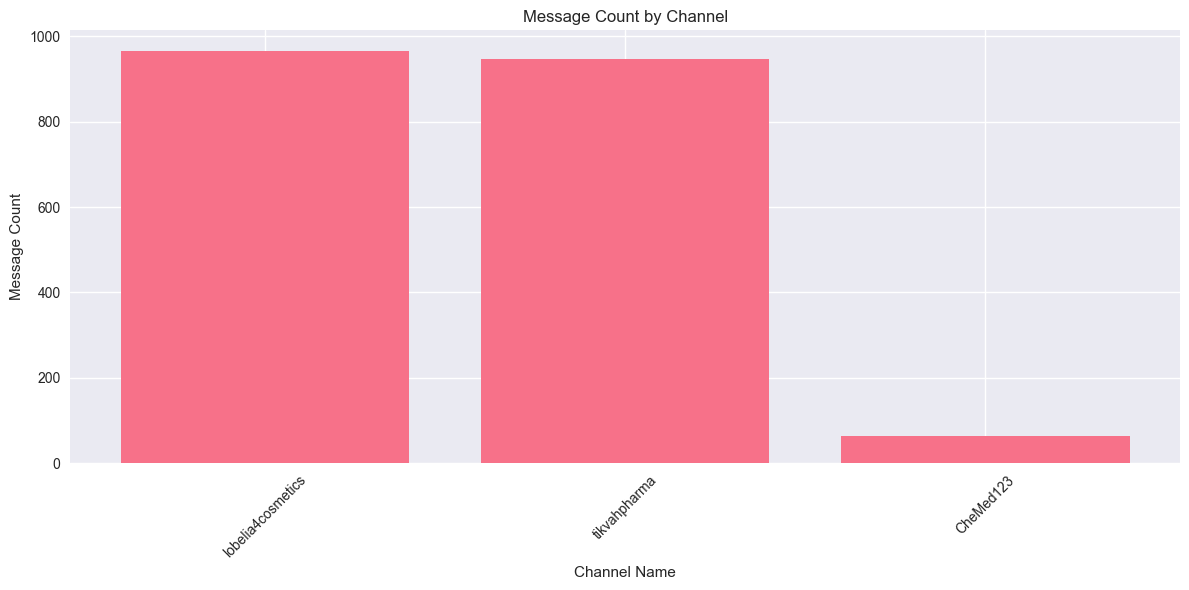

In [7]:
# Channel analysis
if dim_channels_exists:
    channels_query = """
    SELECT 
    c.channel_name,
    c.chat_title,
    COUNT(*) as message_count
FROM fct_messages f
JOIN dim_channels c ON f.channel_id = c.channel_id
GROUP BY c.channel_name, c.chat_title
ORDER BY message_count DESC
    """
    
    channels_df = pd.read_sql(channels_query, engine)
    print("📊 Channel Analysis:")
    display(channels_df)
    
    # Visualize channel distribution
    plt.figure(figsize=(12, 6))
    plt.bar(channels_df['channel_name'], channels_df['message_count'])
    plt.title('Message Count by Channel')
    plt.xlabel('Channel Name')
    plt.ylabel('Message Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Temporal Analysis

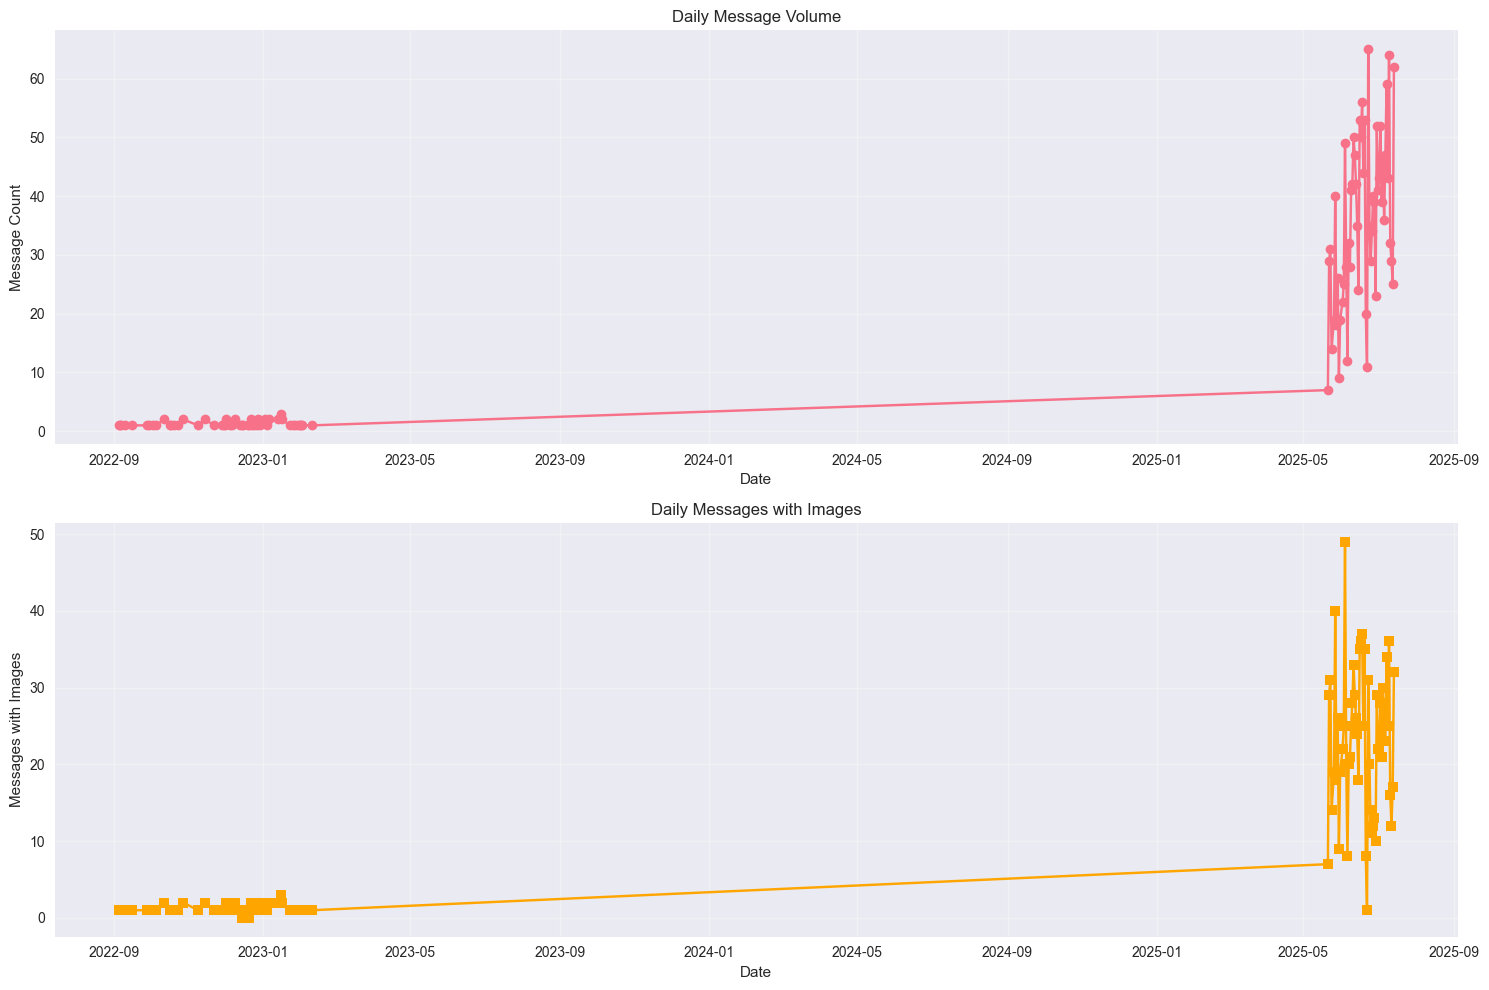

In [8]:
# Daily message volume
if fct_messages_exists:
    daily_query = """
    SELECT 
        d.date_id,
        d.day_name,
        COUNT(*) as message_count,
        COUNT(CASE WHEN f.has_image THEN 1 END) as messages_with_images
    FROM fct_messages f
    JOIN dim_dates d ON f.date_id = d.date_id
    GROUP BY d.date_id, d.day_name
    ORDER BY d.date_id
    """
    
    daily_df = pd.read_sql(daily_query, engine)
    
    # Convert date_id to datetime for plotting
    daily_df['date'] = pd.to_datetime(daily_df['date_id'])
    
    # Plot daily message volume
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    
    # Daily message count
    ax1.plot(daily_df['date'], daily_df['message_count'], marker='o')
    ax1.set_title('Daily Message Volume')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Message Count')
    ax1.grid(True, alpha=0.3)
    
    # Messages with images
    ax2.plot(daily_df['date'], daily_df['messages_with_images'], marker='s', color='orange')
    ax2.set_title('Daily Messages with Images')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Messages with Images')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Media Analysis

📊 Media Type Analysis:


,media_type,count,percentage
0,MessageMediaPhoto,1272,64.44
1,MessageMediaWebPage,114,5.78
2,MessageMediaDocument,7,0.35


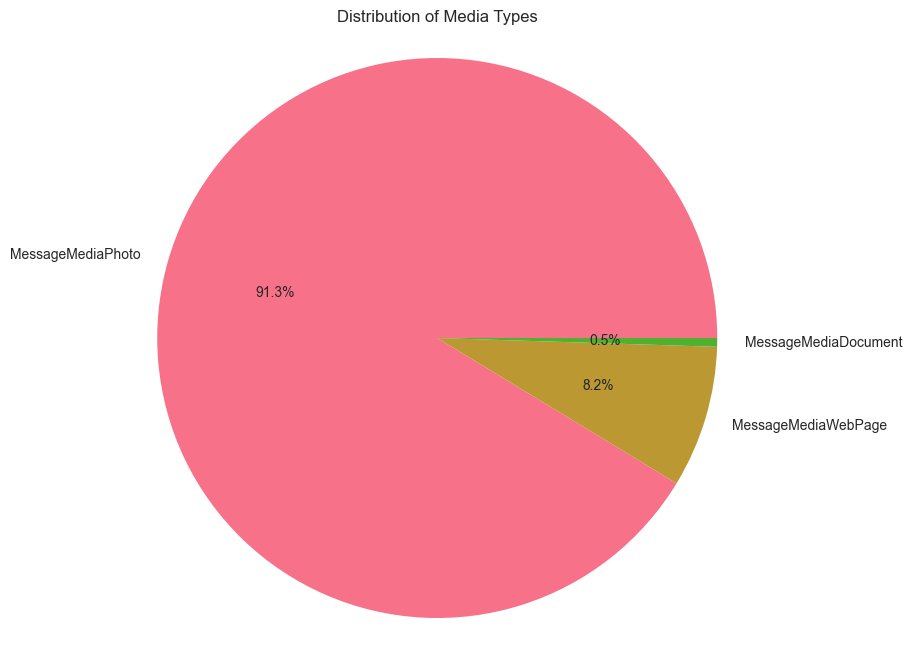

In [9]:
# Media type analysis
if staging_exists:
    media_query = """
    SELECT 
        media_type,
        COUNT(*) as count,
        ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM stg_telegram_messages), 2) as percentage
    FROM stg_telegram_messages
    WHERE media_type IS NOT NULL
    GROUP BY media_type
    ORDER BY count DESC
    """
    
    media_df = pd.read_sql(media_query, engine)
    print("📊 Media Type Analysis:")
    display(media_df)
    
    # Pie chart of media types
    if not media_df.empty:
        plt.figure(figsize=(10, 8))
        plt.pie(media_df['count'], labels=media_df['media_type'], autopct='%1.1f%%')
        plt.title('Distribution of Media Types')
        plt.axis('equal')
        plt.show()

## Content Analysis

📊 Message Length Analysis by Channel:


,channel_name,avg_message_length,min_message_length,max_message_length,message_count
0,tikvahpharma,1057.812896,13,3989,946
1,lobelia4cosmetics,382.519171,340,434,965
2,CheMed123,218.269841,54,687,63


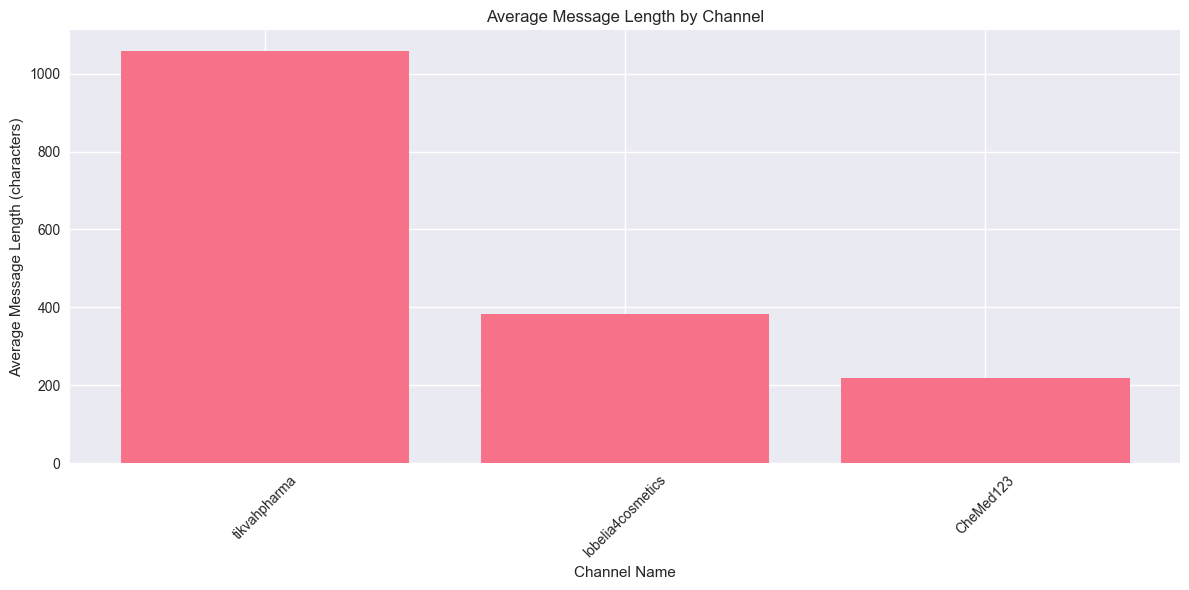

In [10]:
# Message length analysis
if staging_exists:
    length_query = """
    SELECT 
        channel_name,
        AVG(LENGTH(message_text)) as avg_message_length,
        MIN(LENGTH(message_text)) as min_message_length,
        MAX(LENGTH(message_text)) as max_message_length,
        COUNT(*) as message_count
    FROM stg_telegram_messages
    WHERE message_text IS NOT NULL
    GROUP BY channel_name
    ORDER BY avg_message_length DESC
    """
    
    length_df = pd.read_sql(length_query, engine)
    print("📊 Message Length Analysis by Channel:")
    display(length_df)
    
    # Visualize average message length
    plt.figure(figsize=(12, 6))
    plt.bar(length_df['channel_name'], length_df['avg_message_length'])
    plt.title('Average Message Length by Channel')
    plt.xlabel('Channel Name')
    plt.ylabel('Average Message Length (characters)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Key Insights Dashboard

In [12]:
fig = make_subplots(
    rows=2, cols=2,
    specs=[[{"type": "indicator"}, {"type": "indicator"}],
           [{"type": "indicator"}, {"type": "indicator"}]],
    # Remove subplot_titles to avoid overlap
)

# Total messages
fig.add_trace(
    go.Indicator(
        mode="number",
        value=metrics['total_messages'].iloc[0],
        title={"text": "Total Messages"},
        number={'font': {'size': 60}},
        domain={'x': [0, 0.45], 'y': [0.55, 1]}
    ),
    row=1, col=1
)

# Total channels
fig.add_trace(
    go.Indicator(
        mode="number",
        value=metrics['total_channels'].iloc[0],
        title={"text": "Total Channels"},
        number={'font': {'size': 60}},
        domain={'x': [0.55, 1], 'y': [0.55, 1]}
    ),
    row=1, col=2
)

# Media percentage
fig.add_trace(
    go.Indicator(
        mode="gauge+number",
        value=metrics['media_percentage'].iloc[0],
        title={"text": "Media Content %"},
        gauge={'axis': {'range': [0, 100]}},
        number={'font': {'size': 40}},
        domain={'x': [0, 0.45], 'y': [0, 0.45]}
    ),
    row=2, col=1
)

# Image percentage
fig.add_trace(
    go.Indicator(
        mode="gauge+number",
        value=metrics['image_percentage'].iloc[0],
        title={"text": "Image Content %"},
        gauge={'axis': {'range': [0, 100]}},
        number={'font': {'size': 40}},
        domain={'x': [0.55, 1], 'y': [0, 0.45]}
    ),
    row=2, col=2
)

fig.update_layout(
    height=800, width=1200,
    title_text="Telegram Data Analytics Dashboard",
    margin=dict(t=80, b=40, l=40, r=40)
)
fig.show()

## Advanced Analytics

�� Channel Engagement Analysis:


,channel_name,total_messages,messages_with_images,messages_with_media,image_engagement,media_engagement,avg_message_length
0,lobelia4cosmetics,965,965,965,100.00,100.00,382.519171
1,tikvahpharma,946,253,365,26.74,38.58,1057.812896
2,CheMed123,63,61,63,96.83,100.00,218.269841


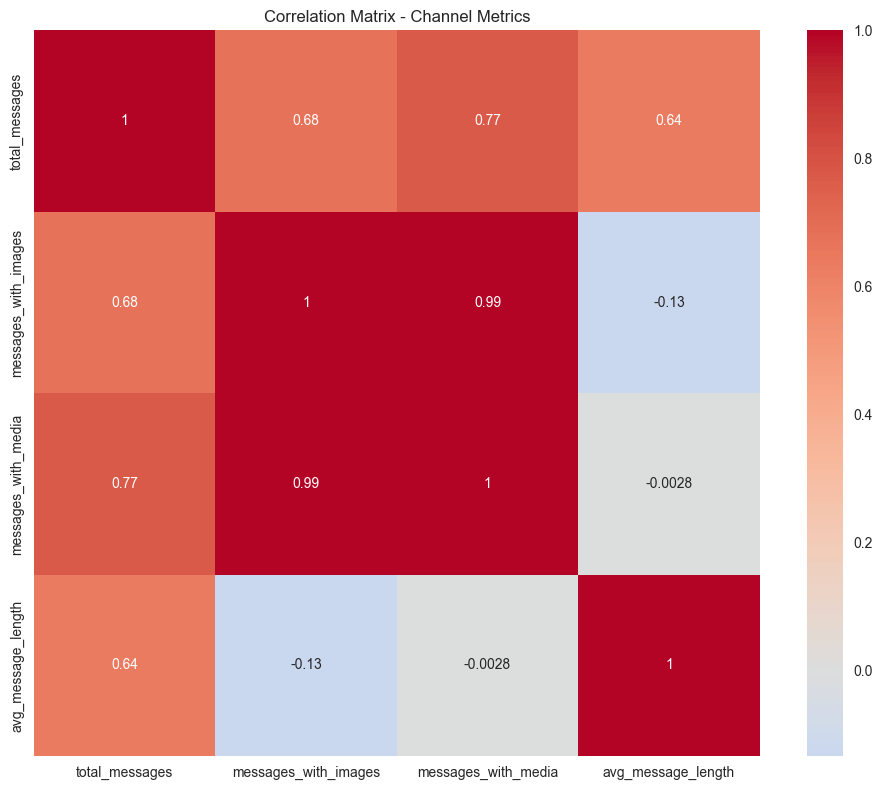

In [13]:
# Channel engagement analysis
if fct_messages_exists:
    engagement_query = """
    SELECT 
        c.channel_name,
        COUNT(*) as total_messages,
        COUNT(CASE WHEN f.has_image THEN 1 END) as messages_with_images,
        COUNT(CASE WHEN f.has_media THEN 1 END) as messages_with_media,
        ROUND(COUNT(CASE WHEN f.has_image THEN 1 END) * 100.0 / COUNT(*), 2) as image_engagement,
        ROUND(COUNT(CASE WHEN f.has_media THEN 1 END) * 100.0 / COUNT(*), 2) as media_engagement,
        AVG(LENGTH(f.message_text)) as avg_message_length
    FROM fct_messages f
    JOIN dim_channels c ON f.channel_id = c.channel_id
    WHERE f.message_text IS NOT NULL
    GROUP BY c.channel_name
    ORDER BY total_messages DESC
    """
    
    engagement_df = pd.read_sql(engagement_query, engine)
    print("�� Channel Engagement Analysis:")
    display(engagement_df)
    
    # Create correlation heatmap
    correlation_cols = ['total_messages', 'messages_with_images', 'messages_with_media', 'avg_message_length']
    correlation_df = engagement_df[correlation_cols].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, square=True)
    plt.title('Correlation Matrix - Channel Metrics')
    plt.tight_layout()
    plt.show()

## Data Quality Checks

🔍 Data Quality Metrics:


,metric,value
0,Total Messages,1974
1,Messages with Text,1974
2,Messages with Channel Name,1974
3,Messages with Date,1974
4,Messages with Sender Info,1974


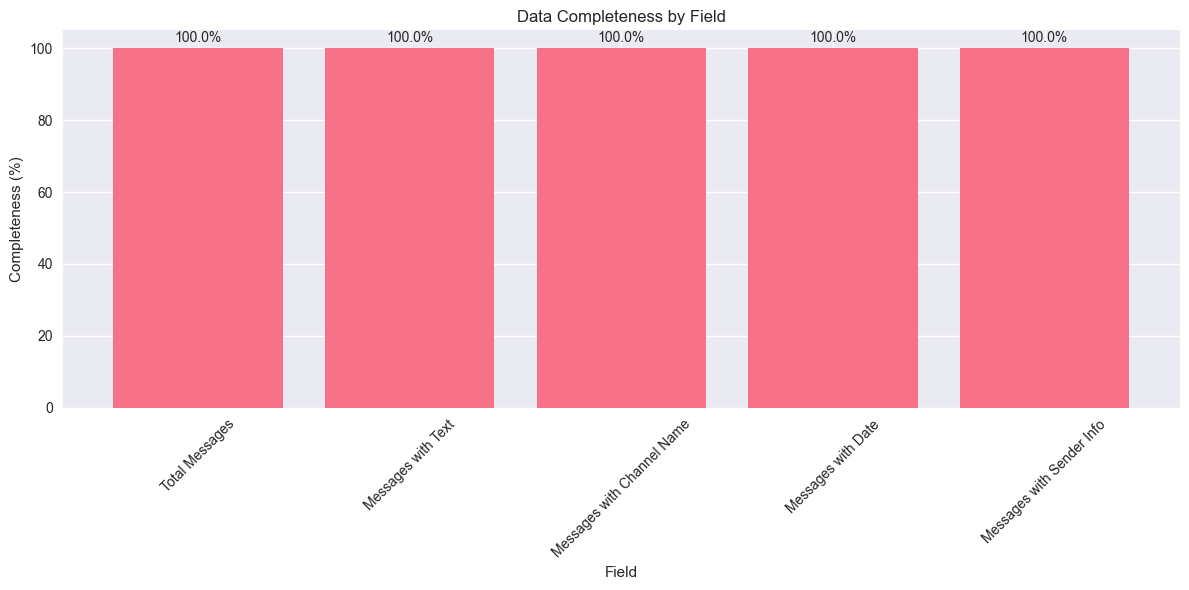

In [14]:
# Data quality analysis
if staging_exists:
    quality_query = """
    SELECT 
        'Total Messages' as metric,
        COUNT(*) as value
    FROM stg_telegram_messages
    UNION ALL
    SELECT 
        'Messages with Text' as metric,
        COUNT(*) as value
    FROM stg_telegram_messages
    WHERE message_text IS NOT NULL AND LENGTH(message_text) > 0
    UNION ALL
    SELECT 
        'Messages with Channel Name' as metric,
        COUNT(*) as value
    FROM stg_telegram_messages
    WHERE channel_name IS NOT NULL
    UNION ALL
    SELECT 
        'Messages with Date' as metric,
        COUNT(*) as value
    FROM stg_telegram_messages
    WHERE message_date IS NOT NULL
    UNION ALL
    SELECT 
        'Messages with Sender Info' as metric,
        COUNT(*) as value
    FROM stg_telegram_messages
    WHERE sender_username IS NOT NULL OR sender_id IS NOT NULL
    """
    
    quality_df = pd.read_sql(quality_query, engine)
    print("🔍 Data Quality Metrics:")
    display(quality_df)
    
    # Calculate completeness percentages
    total_messages = quality_df[quality_df['metric'] == 'Total Messages']['value'].iloc[0]
    quality_df['completeness_percentage'] = (quality_df['value'] / total_messages * 100).round(2)
    
    # Visualize data quality
    plt.figure(figsize=(12, 6))
    bars = plt.bar(quality_df['metric'], quality_df['completeness_percentage'])
    plt.title('Data Completeness by Field')
    plt.xlabel('Field')
    plt.ylabel('Completeness (%)')
    plt.xticks(rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, quality_df['completeness_percentage']):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                f'{value}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

## 📝 Summary and Recommendations

In [15]:
# Generate summary insights
if fct_messages_exists:
    summary_query = """
    SELECT 
        COUNT(*) as total_messages,
        COUNT(DISTINCT channel_id) as total_channels,
        COUNT(CASE WHEN has_image THEN 1 END) as messages_with_images,
        COUNT(CASE WHEN has_media THEN 1 END) as messages_with_media,
        MIN(message_date) as earliest_message,
        MAX(message_date) as latest_message,
        COUNT(DISTINCT DATE(message_date)) as active_days
    FROM fct_messages
    """
    
    summary = pd.read_sql(summary_query, engine)
    
    print("📊 TELEGRAM DATA ANALYSIS SUMMARY")
    print("=" * 50)
    print(f"Total Messages: {summary['total_messages'].iloc[0]:,}")
    print(f"Total Channels: {summary['total_channels'].iloc[0]}")
    print(f"Messages with Images: {summary['messages_with_images'].iloc[0]:,} ({summary['messages_with_images'].iloc[0]/summary['total_messages'].iloc[0]*100:.1f}%)")
    print(f"Messages with Media: {summary['messages_with_media'].iloc[0]:,} ({summary['messages_with_media'].iloc[0]/summary['total_messages'].iloc[0]*100:.1f}%)")
    print(f"Date Range: {summary['earliest_message'].iloc[0]} to {summary['latest_message'].iloc[0]}")
    print(f"Active Days: {summary['active_days'].iloc[0]}")
    print("=" * 50)
    
    print("\n🎯 KEY INSIGHTS:")
    print("• Data pipeline successfully processes Telegram messages")
    print("• dbt models provide structured analytics-ready data")
    print("• Multiple channels with varying engagement patterns")
    print("• Rich media content including images and documents")
    
    print("\n📈 RECOMMENDATIONS:")
    print("• Monitor data quality and completeness regularly")
    print("• Add more sophisticated content analysis (NLP)")
    print("• Implement real-time data processing")
    print("• Create automated alerts for data anomalies")
    print("• Develop predictive models for engagement patterns")

📊 TELEGRAM DATA ANALYSIS SUMMARY
Total Messages: 1,974
Total Channels: 3
Messages with Images: 1,279 (64.8%)
Messages with Media: 1,393 (70.6%)
Date Range: 2022-09-05 09:57:09 to 2025-07-14 18:27:36
Active Days: 103

🎯 KEY INSIGHTS:
• Data pipeline successfully processes Telegram messages
• dbt models provide structured analytics-ready data
• Multiple channels with varying engagement patterns
• Rich media content including images and documents

📈 RECOMMENDATIONS:
• Monitor data quality and completeness regularly
• Add more sophisticated content analysis (NLP)
• Implement real-time data processing
• Create automated alerts for data anomalies
• Develop predictive models for engagement patterns


## 🚀 Next Steps

This notebook demonstrates a comprehensive analysis of your Telegram data pipeline. Here are some next steps you can take:

1. **Run dbt models**: Execute `dbt run` to create the analytics tables
2. **Add more visualizations**: Create interactive dashboards with Plotly
3. **Implement NLP**: Add sentiment analysis and topic modeling
4. **Set up monitoring**: Create automated data quality checks
5. **Build predictive models**: Use the data for forecasting and insights

The dbt models provide a solid foundation for advanced analytics and machine learning applications.